## 흉부 x-ray 사진을 인경신공망 학습을 이용하여 폐렴 환자 구분 하기

### 기본 라이브러리 임포트

In [1]:
########################################
##### 기본적으로 필요한 라이브러리 import #####
########################################
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import cv2
import skimage
import numpy as np
from glob import glob

########################################
##### 머신러닝 관련 라이브러리 import #####
########################################
import sklearn
import scipy
from skimage.transform import resize
import keras.models as km
import keras.layers as kl

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils.np_utils import to_categorical

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### 데이터 경로 설정

In [2]:
train_dir = "../chest_xray/train/"
test_dir =  "../chest_xray/test/" 

### 데이터 크기 설정

In [3]:
# 데이터 크기 (150 x 150)
_N_ROW = 300  # 세로 150
_N_COL = 300  # 가로 150
_N_PIXEL = _N_ROW * _N_COL

### 폴더에 있는 데이터를 읽어서, 추가 및 라벨링을 하는 함수 get_data 설정 

In [4]:
def get_data(folder):
    X = []
    y = []
    
    for folderName in os.listdir(folder):
        print( 'foldername = ' + folderName )
        
        if folderName.startswith('.'):
            continue
        
        if folderName == 'NORMAL':
            label = 0
        elif folderName == 'PNEUMONIA':
            label = 1
        else:
            print("Err! I don't know this data...")
            return

        # out of memory 때문에 커널이 자꾸 죽기 때문에, 이미지 개수를 제한한다. 
        count_num = 0
        for image_filename in tqdm(os.listdir(folder + folderName)):
            count_num += 1 
#             if count_num > 100 : 
#                 break 
            img_file = cv2.imread(folder + folderName + '/' + image_filename)
            
            if img_file is not None: 
                img_file = skimage.transform.resize(img_file, (_N_ROW, _N_COL, 3))
                img_arr = np.asarray(img_file)
                X.append(img_arr)
                y.append(label)
                    
    X = np.asarray(X)
    y = np.asarray(y)
    
    return X,y

### 학습 데이터를 읽어오고 라벨도 읽어온다. 

In [5]:
X_train, y_train = get_data(train_dir)
X_test, y_test= get_data(test_dir)

y_trainHot = to_categorical(y_train, num_classes = 2)
y_testHot = to_categorical(y_test, num_classes = 2)

  0%|          | 0/3876 [00:00<?, ?it/s]/usr/local/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
  0%|          | 2/3876 [00:00<03:49, 16.90it/s]

foldername = .DS_Store
foldername = PNEUMONIA


  0%|          | 0/1342 [00:00<?, ?it/s]

foldername = NORMAL


  1%|          | 2/391 [00:00<00:19, 19.66it/s]

foldername = .DS_Store
foldername = PNEUMONIA


  0%|          | 1/234 [00:00<00:37,  6.20it/s]

foldername = NORMAL


100%|██████████| 234/234 [00:24<00:00,  9.66it/s]


### 이미지를 보여주는 함수 정의 

In [8]:
def show_img(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
#     plt.figure(figsize=(10,5))
#     plt.subplot(1,2,1)
    plt.imshow(a)

### 비정상의 폐

1


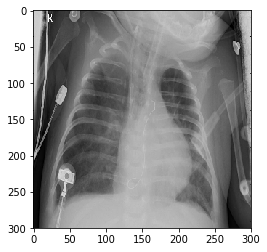

In [9]:
show_img(X_train[0])
print(y_train[0])

1


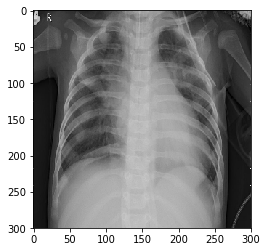

In [10]:
show_img(X_test[0])
print(y_test[0])

### 정상인의 폐

1


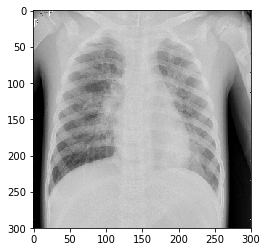

In [11]:
show_img(X_train[1040])
print(y_train[1040])

0


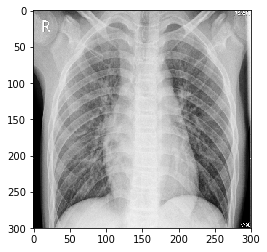

In [12]:
show_img(X_test[623])
print(y_test[623])

### 환자의 폐

비정상!!


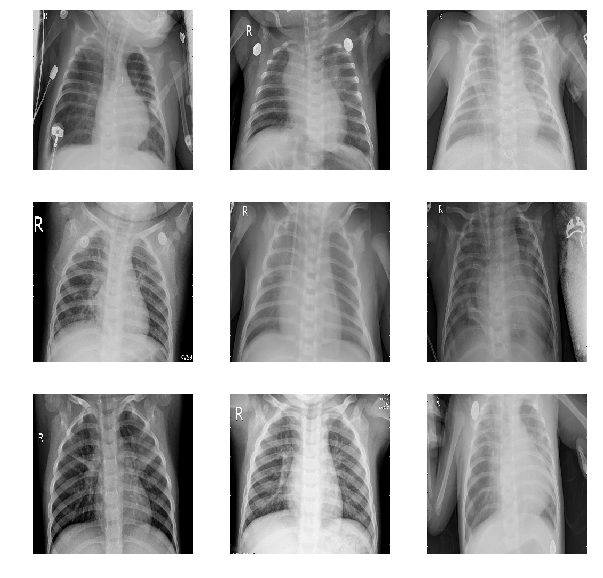

In [13]:
print("비정상!!")
multipleImages = glob('../chest_xray/train/PNEUMONIA/**')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
# plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:9]:
    im = cv2.imread(l)
    im = cv2.resize(im, (_N_ROW , _N_COL)) 
    plt.subplot(3, 3, i_+1) #.set_title(l)
    plt.imshow(im); 
#     plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); 
    plt.axis('off')
    i_ += 1

### 정상인의 폐

정상!!


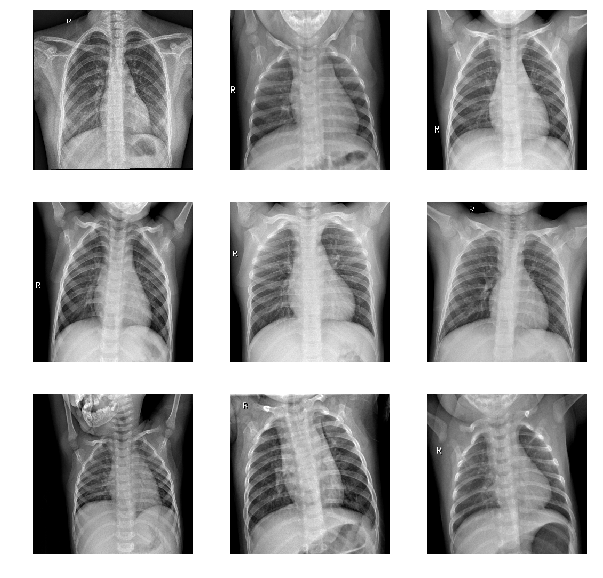

In [14]:
print("정상!!")
multipleImages = glob('../chest_xray/train/NORMAL/**')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
# plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:9]:
    im = cv2.imread(l)
    im = cv2.resize(im, (_N_ROW, _N_COL)) 
    plt.subplot(3, 3, i_+1) #.set_title(l)
    plt.imshow(im); 
#     plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); 
    plt.axis('off')
    i_ += 1

### 에러 확인 함수 생성

In [15]:
def confirmErr(realAnswerList, testAnswerList):
    answerNum = 0
    for i, eachAns in enumerate(realAnswerList):
        if testAnswerList[i] == eachAns:
            answerNum += 1
    return float(len(realAnswerList)-answerNum)/float(len(realAnswerList))*100

### 학습 모델을 설정한다.

In [16]:
def study(trDataList, trLabelList, save_h5_name, log_txt_name):
    trDataList = X_train
    trLabelList = y_trainHot

    # 모델 설정
    model = km.Sequential()
    model.add(kl.Conv2D(input_shape=(_N_ROW, _N_COL, 3), filters=15,
                        kernel_size=(3, 3), strides=1  ))
    model.add(kl.MaxPooling2D(pool_size=(2, 2)))
    model.add(kl.Activation('relu'))
    model.add(kl.Conv2D(input_shape=(_N_ROW, _N_COL, 3), filters=15,
                        kernel_size=(3, 3), strides=1  ))
    model.add(kl.MaxPooling2D(pool_size=(2, 2)))
    model.add(kl.Activation('relu'))
    model.add(kl.Conv2D(filters=15,
                        kernel_size=(3, 3), strides=1  ))
    model.add(kl.Activation('relu'))
    model.add(kl.Flatten())
    model.add(kl.Dense(2, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # 모델 출력 
    print(model.summary())
    print('\n\n\n')

    # 학습 데이터를 추출하여 저장하고 출력한다
    history_callback = model.fit(trDataList, trLabelList, epochs=10, batch_size=500, verbose=2)
    loss_history = history_callback.history
    train_log = ''
    for i in range(len(loss_history['acc'])):
        train_log += "%d epoch _ acc : %.4f, loss : %.4f\n" % ( i+1, loss_history['acc'][i], loss_history['loss'][i] )

    # 로그 기록 
    fd = open(log_txt_name, 'w')
    fd.write(train_log)
    fd.close()

    # 모델 저장 
    km.save_model(model, save_h5_name) 

    # 실제 에러율 확인 
    print ('err is  %f%%' % (confirmErr(np.argmax(trLabelList, axis=1), 
                                        np.argmax(model.predict(trDataList), axis=1))) )
    
    return model

### 학습 수행 

In [18]:
_model = study(trDataList = X_test, trLabelList = y_testHot, save_h5_name= 'model_300x300_1.h5', log_txt_name='model_300x300_1.txt')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 298, 298, 15)      420       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 149, 149, 15)      0         
_________________________________________________________________
activation_4 (Activation)    (None, 149, 149, 15)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 147, 147, 15)      2040      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 73, 73, 15)        0         
_________________________________________________________________
activation_5 (Activation)    (None, 73, 73, 15)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 71, 71, 15)        2040      
__________

### 학습 결과를 test set 으로 확인

In [19]:
trDataList = X_test
trLabelList = y_testHot

# 실제 에러율 확인
print ('The real err is  %f%%' % (confirmErr(np.argmax(trLabelList, axis=1), np.argmax(_model.predict(trDataList), axis=1))) )

The real err is  22.596154%


### 모델 파라미터를 가져와서 test 데이터 셋과 비교합니다

In [20]:
def confirm_study(trDataList, trLabelList):
    test_log = '' 
    # 모델 파라미터 로드
    newModel = km.load_model('model.h5')

    # 테스트
    res = newModel.predict(trDataList)
    print ('res', res.shape)
    print (res)
    print (np.argmax(res, axis=1))
    print ()

    test_log += 'res\n\n'
    test_log += str(res.shape)
    test_log += '\n\n'
    test_log += str(res)
    test_log += '\n\n'
    test_log += str(np.argmax(res, axis=1))
    test_log += '\n\n'

    # 전체 에러 출력
    err = confirmErr(np.argmax(trLabelList, axis=1), np.argmax(res, axis=1))
    print ('Test set err is  %f%%' % ( err ))

    test_log += '\nTest set err is  %f%%\n\n' % (err)

    fd = open('test_log.txt', 'w')
    fd.write(test_log)
    fd.close()

In [30]:
trDataList = X_test
trLabelList = y_testHot

confirm_study(trDataList, trLabelList)

res (200, 2)
[[ 0.40065441  0.59934562]
 [ 0.37865168  0.62134826]
 [ 0.36652836  0.63347155]
 [ 0.36283416  0.63716584]
 [ 0.42699265  0.57300735]
 [ 0.3695049   0.63049513]
 [ 0.42766535  0.57233465]
 [ 0.47247884  0.52752113]
 [ 0.38120604  0.61879396]
 [ 0.41807187  0.58192819]
 [ 0.46102351  0.53897655]
 [ 0.36381125  0.63618875]
 [ 0.45230317  0.54769683]
 [ 0.46187937  0.53812063]
 [ 0.39432648  0.60567349]
 [ 0.45906234  0.54093766]
 [ 0.38675377  0.61324626]
 [ 0.37412065  0.62587935]
 [ 0.4713167   0.5286833 ]
 [ 0.45820084  0.54179913]
 [ 0.3997471   0.60025287]
 [ 0.3724795   0.6275205 ]
 [ 0.43017918  0.56982088]
 [ 0.32728738  0.67271262]
 [ 0.34465358  0.65534651]
 [ 0.49502534  0.50497466]
 [ 0.34094384  0.65905619]
 [ 0.43317881  0.56682122]
 [ 0.32482624  0.67517376]
 [ 0.43247452  0.56752545]
 [ 0.35689729  0.64310265]
 [ 0.4450053   0.55499476]
 [ 0.36723065  0.63276935]
 [ 0.363673    0.63632703]
 [ 0.37385285  0.62614721]
 [ 0.5258581   0.47414193]
 [ 0.36869606  

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

In [20]:
X_train[0].shape

(150, 150, 3)

In [21]:
X_train.shape

(5216, 150, 150, 3)